In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import camb 
import healpy as hp

import lensit as li
from lensit.clusterlens import lensingmap, profile 
from lensit.misc.misc_utils import gauss_beam
from lensit.ffs_covs import ffs_cov, ell_mat

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline
from plancklens.wigners import wigners
from plancklens import n0s

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [2]:
def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def pp_to_kk(ls):
    return ls ** 2 * (ls+1.) ** 2 * 0.25 

def p_to_k(ls):
    return ls * (ls+1.) * 0.5

def kk_to_pp(ls):
    return cli(pp_to_kk(ls))

def k_to_p(ls):
    return cli(p_to_k(ls))

def th_amin_to_el(th_amin):
    th_rd = (th_amin/60)*(np.pi/180)
    return np.pi/th_rd


In [3]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'

pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)

In [4]:
# We define here the parameters for the profile of the cluster
M200, z = 2 * 1e14, 0.7
profname = 'nfw'
key = "cluster" # "lss"/"cluster"/"lss_plus_cluster"
profparams={'M200c':M200, 'z':z}

# Define here the map square patches
npix = 1024  # Number of pixels
lpix_amin = 0.3 # Physical size of a pixel in arcmin (There is bug when <0.2 amin, due to low precision in Cl_TE at )

print("The size of the data patch is %0.1f X %0.1f arcmin central box"%(npix*lpix_amin, npix*lpix_amin))

# Maximum multipole used to generate the CMB maps from the CMB power spectra
# ellmaxsky = 6000 # (bug when ellmax>6300 because of low precision in Cl_TE of CAMB )
ellmaxsky = 8000 

# Set the maximum ell observed in the CMB data maps
ellmaxdat = 4000
ellmindat = 100

# Number of simulated maps 
nsims = 1000

# Set CMB experiment for noise level and beam
cmb_exp='S4_opti'

# We will cache things in this directory 
libdir = lensingmap.get_cluster_libdir(cambinifile,  profname, key, npix, lpix_amin, ellmaxsky, M200, z, nsims, cmb_exp)
print(libdir)

The size of the data patch is 307.2 X 307.2 arcmin central box
/Users/sayan/Project_Geneva/modules/LensIt/lensit/temp/clustermaps/camb_planck_2018_acc/cmbexp_S4_sayan/nfw_profile/lensed_by_cluster/npix1024_lpix_0.3amin_lmaxsky8000/M200_2.000000E+14_z0.7/1000_sims


In [5]:
lmax = ellmaxsky
cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

# cl's are 10
# 0 times smalller
camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}
#cls_unl_fid_1 = {'tt':camb_cls[0]/100, 'ee':camb_cls[1]/100, 'bb':camb_cls[2]/100, 'te':camb_cls[3]/100, 'pp':cpp_fid}



In [6]:
np.random.seed(seed=20)
clustermaps = lensingmap.cluster_maps(libdir, key, npix, lpix_amin, nsims, results, profparams, profilename=profname,  ellmax_sky = ellmaxsky, ellmax_data=ellmaxdat, ellmin_data=ellmindat, cmb_exp=cmb_exp)

/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:293: RuntimeWarning: invalid value encountered in true_divide
  dx_lm = 2 * rfft_kappa * 1.j * KX / (KX**2+KY**2)
/Users/sayan/Project_Geneva/modules/LensIt/lensit/clusterlens/profile.py:294: RuntimeWarning: invalid value encountered in true_divide
  dy_lm = 2 * rfft_kappa * 1.j * KY / (KX**2+KY**2)


In [7]:
ellmax_sky = clustermaps.ellmax_sky
sN_uKamin, sN_uKaminP, Beam_FWHM_amin, ellmin, ellmax = li.get_config(clustermaps.cmb_exp)
transf = hp.gauss_beam(1. / 180 / 60 * np.pi, lmax=ellmax_sky)
cls_noise = {'t': (sN_uKamin * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'q':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1),
            'u':(sN_uKaminP * np.pi / 180. / 60.) ** 2 * np.ones(clustermaps.ellmax_sky + 1)}  # simple flat noise Cls

cl_transf = clustermaps.cl_transf
lib_skyalm = clustermaps.lib_skyalm

typ = 'QU'

lib_dir = op.join(clustermaps.dat_libdir, typ, 'len')
isocov = ffs_cov.ffs_diagcov_alm(lib_dir, clustermaps.lib_datalm, cls_unl_fid, cls_unl_fid, cl_transf, cls_noise, lib_skyalm=lib_skyalm)

In [8]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])
kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)

hprofile = profile.profile(results, profname)
xmax = hprofile.get_concentration(M200, z) # truncating at virial radius seems like at reasonable thing
lmax = ellmaxsky
thtmax = hprofile.x_to_theta_amin(M200, z, xmax)
thtscale = hprofile.x_to_theta_amin(M200, z, 1.)
 
print('thmax in amin, thscale', thtmax, thtscale)
xg, wg = wigners.get_xgwg(np.cos(thtmax / 180 / 60 * np.pi),1., max(5000, int(lmax * thtmax / (360 * 60))))
kappa = hprofile.kappa_theta(M200, z, np.arccos(xg) / np.pi * 180 * 60 )
kappa_ell = wigners.wignercoeff(kappa * wg, xg, 0, 0, lmax)

thmax in amin, thscale 2.139100514187885 0.6846534736764758


In [9]:
ell, = np.where(lib_skyalm.get_Nell()[:ellmaxsky+1])

kappa_map = clustermaps.get_kappa_map(clustermaps.M200, clustermaps.z)
#kappa_map = clustermaps.len_cmbs.kappa_map

ckk_map = lib_skyalm.map2cl(kappa_map)
#ckk_map = kappa_ell**2/4/np.pi
cpp_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1)) * kk_to_pp(np.arange(ellmaxsky+1))
ckk_map_interp = 10**spline(ell, np.log10(ckk_map[ell]))(np.arange(ellmaxsky+1))


#kappa_ell = clustermaps.haloprofile.analitic_kappa_ft(clustermaps.M200, clustermaps.z, np.arange(ellmax_sky+1))
ckk_fid = kappa_ell **2 
cpp_fid = kk_to_pp(np.arange(ellmax_sky+1))*ckk_fid


cpp_prior = np.copy(cpp_map_interp)
cpp_prior = cpp_prior[:isocov.lib_skyalm.ellmax +1]
ckk_prior = np.copy(ckk_map_interp)
ckk_prior = ckk_prior[:isocov.lib_skyalm.ellmax +1]

ckk_alm = lib_skyalm.map2alm(kappa_map)

ckk_bin = lib_skyalm.bin_realpart_inell(ckk_alm)
# To bin in disk 

ell, = np.where(clustermaps.lib_datalm.get_Nell()[:ellmaxsky+1])
# cpp_prior = cpp_prior * kk_to_pp(np.arange(isocov.lib_skyalm.ellmax +1)

In [10]:
def get_starting_point(idx, typ, clustermaps): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 

    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    # isocov.lib_datalm defines the mode-filtering applied on the data, 
    # and isocov.lib_skyalm the band-limits of the unlensed sky.
    lib_qlm = lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    ellmax_sky = lib_skyalm.ellmax
    ell = np.arange(ellmax_sky+1)
    # lib_qlm = isocov.lib_datalm #: This means we will reconstruct the lensing potential for data modes.

    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    if typ=='QU':
        datalms = np.array([isocov.lib_datalm.map2alm(m) for m in clustermaps.maps_lib.get_sim_qumap(idx)]) 
    elif typ =='T':
        datalms = np.array([isocov.lib_datalm.map2alm(clustermaps.maps_lib.get_sim_tmap(idx))]) 
    
    use_cls_len = False
    
    H0len =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0])
    plm = 0.5 * isocov.get_qlms(typ,  isocov.get_iblms(typ, datalms, use_cls_len=use_cls_len)[0], lib_qlm, 
                                 use_cls_len=use_cls_len)[0]
    
    # Normalization and Wiener-filtering:
    # cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]

    plmqe  = lib_qlm.almxfl(plm, cli(H0len), inplace=False)
    klmqe  = lib_qlm.almxfl(plmqe, p_to_k(ell), inplace=False)
    plm0  = lib_qlm.almxfl(plm, cli(H0len + cli(cpp_prior[:lib_qlm.ellmax+1])), inplace=False)
    #klm0  = lib_qlm.almxfl(plm0, p_to_k(ell), inplace=False)
    klm0 = lib_qlm.almxfl(klmqe, ckk_prior[:lib_skyalm.ellmax+1]*cli(cli(H0len)*pp_to_kk(ell) + ckk_prior[:lib_skyalm.ellmax+1]), inplace=False)
    wf_qe = np.zeros(lib_qlm.ellmax+1)
    wf_qe_kk = np.zeros(lib_qlm.ellmax+1)
    ell, = np.where(lib_qlm.get_Nell()[:isocov.lib_datalm.ellmax])
    
    wf_qe[ell] = cpp_prior[ell] * cli(cpp_prior[ell] + cli(H0len[ell]))
    wf_qe_kk[ell] = ckk_prior[ell]*cli(ckk_prior[ell] + cli(H0len[ell])*pp_to_kk(ell))

    # wf_qe = cpp_prior[:lib_qlm.ellmax+1] * cli(cpp_prior[:lib_qlm.ellmax+1] + cli(H0len[:lib_qlm.ellmax+1]))
    # wf_qe = spline(ell, wf_qe_0[ell])(np.arange(lib_qlm.ellmax+1))


    # Initial likelihood curvature guess. We use here N0 as calculated with unlensed CMB spectra:
    H0unl =  cli(isocov.get_N0cls(typ, lib_qlm, use_cls_len=False)[0])
    return plm0, plmqe, klm0, klmqe, H0len, wf_qe, wf_qe_kk


idx = 0
plm0, plmqe, klm0, klmqe, H0len, wf_qe, wf_qe_kk= get_starting_point(idx, typ, clustermaps)

 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


In [122]:
plm0_T, plmqe_T, klm0_T, klmqe_T, H0len_T, wf_qe_T, wf_qe_kk_T= get_starting_point(0,'T', clustermaps)
plm0_P, plmqe_QU, klm0_P, klmqe_P, H0len_P, wf_qe_P, wf_qe_kk_P= get_starting_point(0,'QU', clustermaps)


 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


Text(0.5, 1.0, 'lmax=4000, lmin=100 with unlensed Cls')

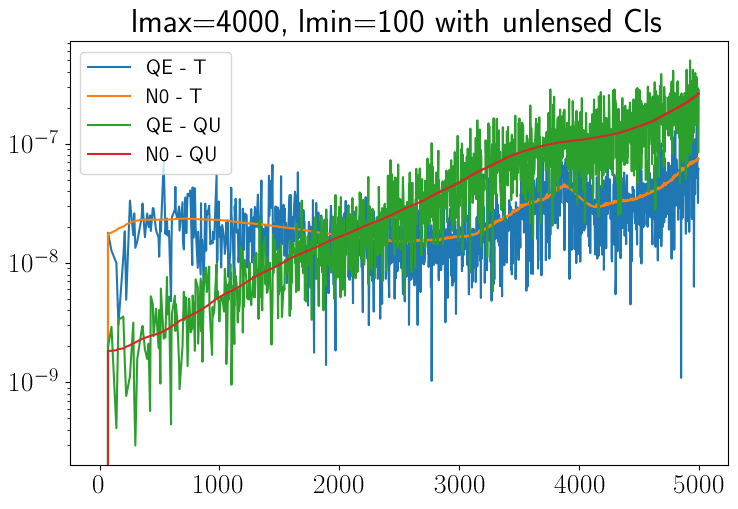

In [123]:
lib_qlm = isocov.lib_skyalm
ell, = np.where(isocov.lib_skyalm.get_Nell()[:5000])
plt.semilogy(ell, lib_qlm.alm2cl(plmqe_T)[ell]  * pp_to_kk(ell), label='QE - T')
plt.plot(ell, cli(H0len_T)[ell]*pp_to_kk(ell), label='N0 - T')
plt.semilogy(ell, lib_qlm.alm2cl(plmqe_QU)[ell]  * pp_to_kk(ell), label='QE - QU')
plt.plot(ell, cli(H0len_P)[ell]*pp_to_kk(ell), label='N0 - QU')
#plt.plot(ell, Nl[ell]*pp_to_kk(ell), label='N0 bias from plancklens with unlensed Cl')
plt.legend()
plt.title("lmax=%i, lmin=%i with unlensed Cls"%(ellmaxdat,ellmindat))
#plt.savefig("QE_nd_N0_qith_pol.pdf")

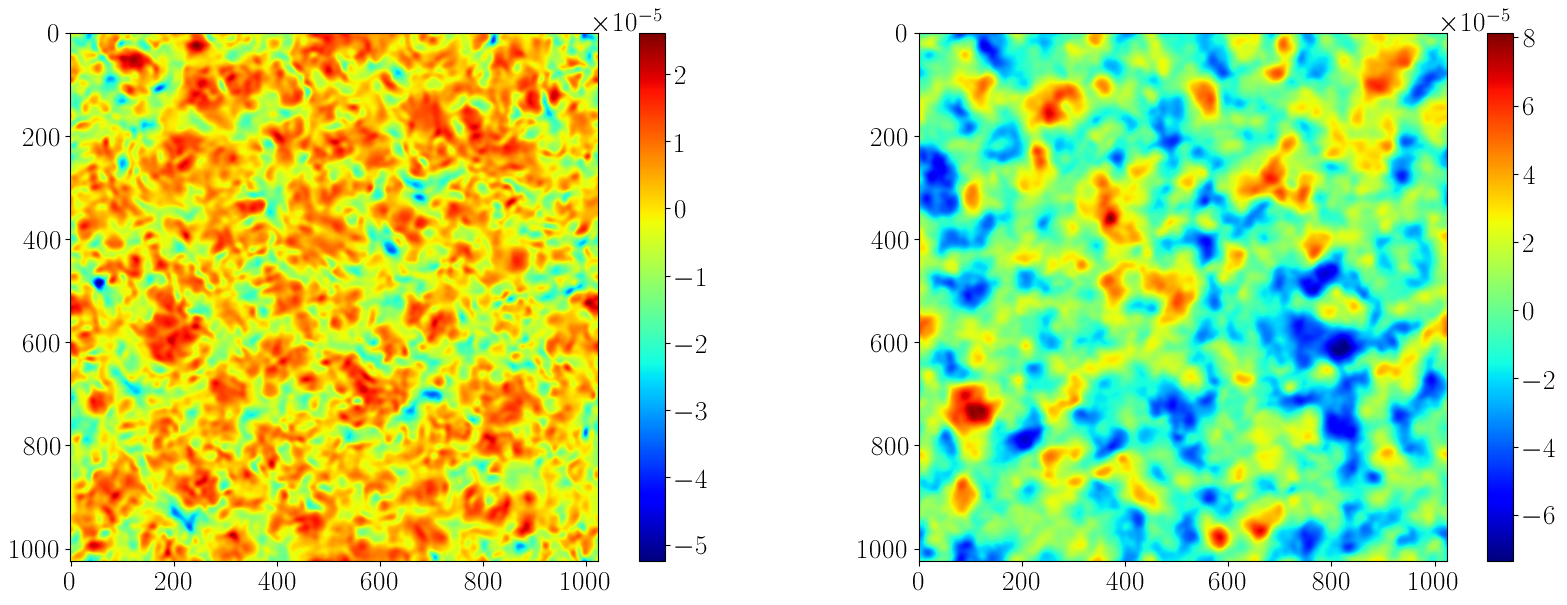

In [140]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm2klm(plm0)), clustermaps.len_cmbs.kappa_map]):
for ax, dat in zip(axs, [lib_skyalm.alm2map(klm0_T), lib_skyalm.alm2map(klm0_P)]):
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)

In [128]:
kappa_input = clustermaps.len_cmbs.kappa_map
phi_input = clustermaps.len_cmbs._get_f().get_phi()
lib_qlm = isocov.lib_skyalm

klm_input = lib_qlm.map2alm(kappa_input)
plm_input = lib_qlm.map2alm(phi_input)

kappa_input_wf_T = lib_qlm.alm2map(lib_qlm.almxfl(klm_input,  wf_qe_kk_T , inplace=False))
phi_input_wf_T = lib_qlm.alm2map(lib_qlm.almxfl(plm_input,  wf_qe_P , inplace=False))

kappa_input_wf_P = lib_qlm.alm2map(lib_qlm.almxfl(klm_input,  wf_qe_kk_P , inplace=False))
phi_input_wf_P = lib_qlm.alm2map(lib_qlm.almxfl(plm_input,  wf_qe_P , inplace=False))

Text(0.5, 1.0, '$\\kappa_{WF}$ map')

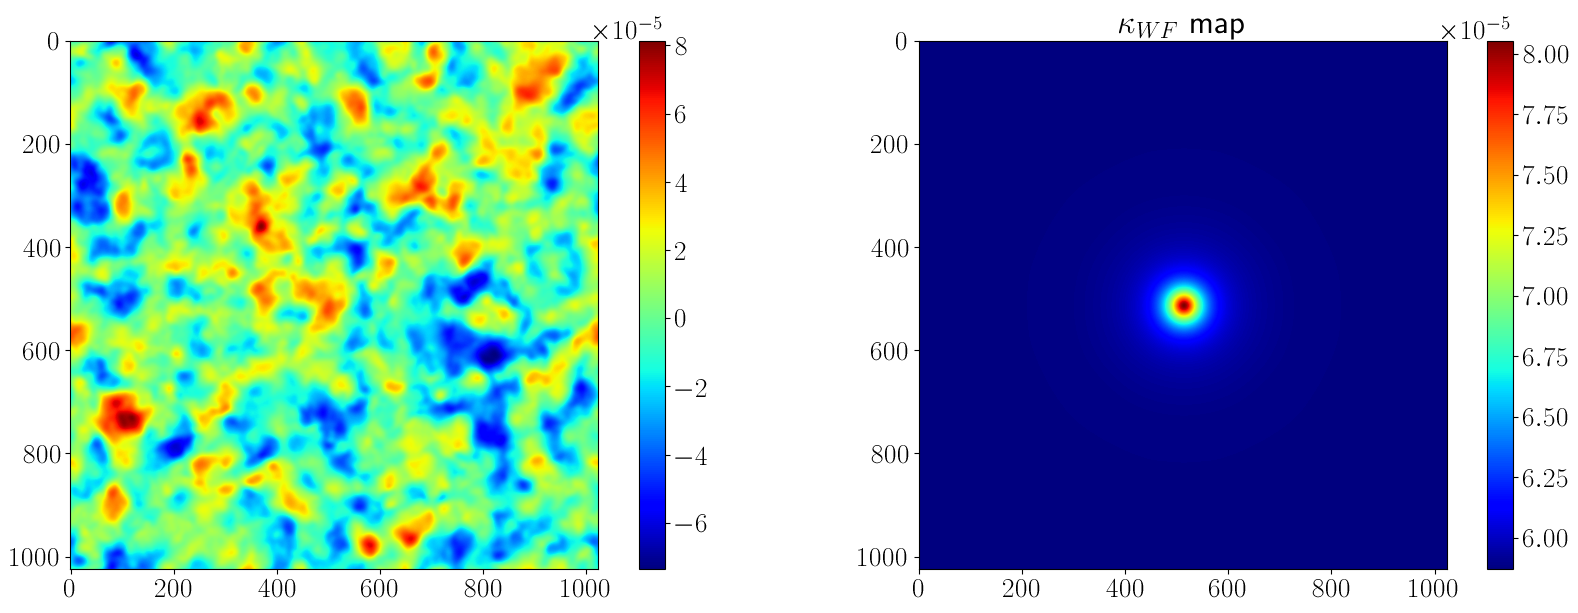

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm2klm(plm0)), clustermaps.len_cmbs.kappa_map]):
for ax, dat in zip(axs, [lib_qlm.alm2map(klm0_P), kappa_input_wf_P]):
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)

plt.title(r"$\kappa_{WF}$ map")

Text(0.5, 1.0, '$\\phi_{WF}$ map')

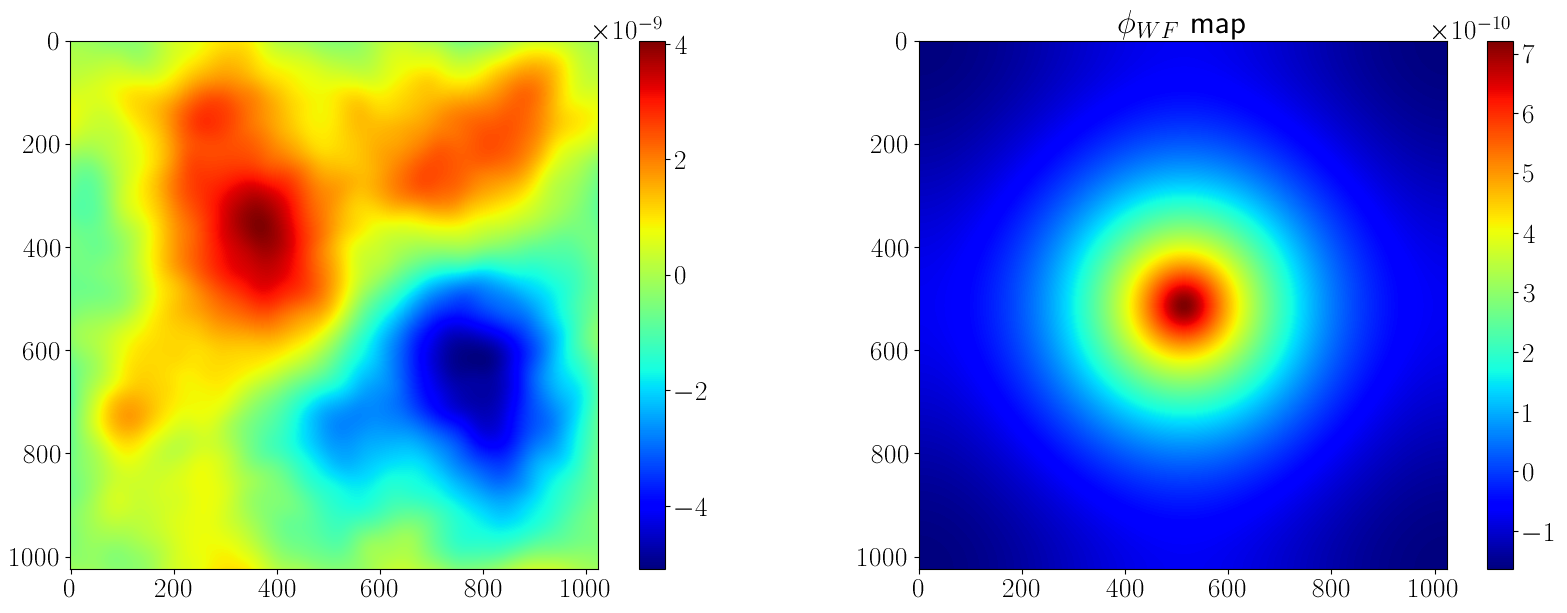

In [138]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1.4, top=0.94, wspace=0.05)
# for ax, dat in zip(axs, [lib_qlm.alm2map(plm2klm(plm0)), clustermaps.len_cmbs.kappa_map]):
for ax, dat in zip(axs, [lib_qlm.alm2map(plm0_P), phi_input_wf_P]):
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)
    
plt.title(r"$\phi_{WF}$ map")


In [17]:
typ = 'T'
lib_qlm = isocov.lib_skyalm
use_cls_len = True
NL = isocov.get_N0cls(typ, lib_qlm, use_cls_len=use_cls_len)[0]
kappa0 = hprofile.get_kappa0(M200,z)
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)

def kappa_0_fs(lmin, lmax, phi_obs_lm, NL):
    """ Get the kappa_0 estimate from one simulation
        Args: 
            lmin, lmax: the lrange for the sum in the numerator and denominator of the estimator
            phi_obs_lm: phi (lensing potential) estimate of a single simulation/observation
            NL: reconstruction niose of the phi estimate
        Returns:
            kappa_0 estiamte for the single simulation/observation
            
        P.S. the arguments is taken as the phi (not kappa) of the observation and accordingly the noise
    """
    ell, = np.where(clustermaps.lib_skyalm.get_Nell()[:lmax+1] > 1)
    for i in range(len(ell)):
        if ell[i] >= lmin:
            m = i
            break
    ell = ell[m:]
    num_l = clustermaps.lib_skyalm.get_Nell()[ell]
    phi_obs_el = clustermaps.lib_skyalm.bin_realpart_inell(phi_obs_lm) #the average 
    denom_int = (num_l)*(kappa_ell[ell]/lbox_rad/kappa0)**2 /(NL[ell]*pp_to_kk(ell))
    num_int = (num_l)*(kappa_ell[ell]/lbox_rad/kappa0)*phi_obs_el[ell]*(ell+1)*ell /2 /(NL[ell]*pp_to_kk(ell)) ## since the observed quantity is phi and we need kappa
    denom1 = np.sum(denom_int)
    numer1 = np.sum(num_int)
    return numer1/denom1 

In [20]:
nmaps = 1000
plm0s_T = [None]*nmaps
plmqes_T = [None]*nmaps
pmaps0_T = [None]*nmaps
pmapsqe_T = [None]*nmaps
klm0s_T = [None]*nmaps
klmqes_T = [None]*nmaps
kmaps0_T = [None]*nmaps
kmapsqe_T = [None]*nmaps
kappa_0_sims_1_T = [None]*nmaps
kappa_l_hat_1_T = [None]*nmaps
lmax, lmin= 5000,10
ell = np.arange(ellmaxsky+1)
if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plm0s_T[idx], plmqes_T[idx], klm0s_T[idx], klmqes_T[idx], H0len, wf_qe, wf_qe_kk = get_starting_point(idx, 'T', clustermaps)
        # pmaps0[idx] = lib_qlm.alm2map(plm2alphalm(plm0s[idx]))
        # pmapsqe[idx] = lib_qlm.alm2map(plm2alphalm(plmqes[idx]))
        # kmaps[idx] = lib_qlm.alm2map(plm2klm(plm0s[idx]))

        pmaps0_T[idx] = lib_qlm.alm2map(plm0s_T[idx])
        pmapsqe_T[idx] = lib_qlm.alm2map(plmqes_T[idx])
        
        kmaps0_T[idx] = lib_qlm.alm2map(klm0s_T[idx])
        kmapsqe_T[idx] = lib_qlm.alm2map(klmqes_T[idx])
        
        kappa_l_hat_1_T[idx] = clustermaps.lib_skyalm.bin_realpart_inell(plmqes_T[idx])*(ell+1)*ell /2
        kappa_0_sims_1_T[idx] = kappa_0_fs(lmin=lmin, lmax=lmax, phi_obs_lm=plmqes_T[idx], NL=cli(H0len))

0
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total

In [18]:
nmaps = 1000
plm0s_P = [None]*nmaps
plmqes_P = [None]*nmaps
pmaps0_P = [None]*nmaps
pmapsqe_P = [None]*nmaps
klm0s_P = [None]*nmaps
klmqes_P = [None]*nmaps
kmaps0_P = [None]*nmaps
kmapsqe_P = [None]*nmaps
kappa_0_sims_1_P = [None]*nmaps
kappa_l_hat_1_P = [None]*nmaps
lmax, lmin= 5000,10
ell = np.arange(ellmaxsky+1)
if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plm0s_P[idx], plmqes_P[idx], klm0s_P[idx], klmqes_P[idx], H0len, wf_qe, wf_qe_kk = get_starting_point(idx, 'QU', clustermaps)
        # pmaps0[idx] = lib_qlm.alm2map(plm2alphalm(plm0s[idx]))
        # pmapsqe[idx] = lib_qlm.alm2map(plm2alphalm(plmqes[idx]))
        #kmaps[idx] = lib_qlm.alm2map(plm2klm(plm0s[idx]))

        pmaps0_P[idx] = lib_qlm.alm2map(plm0s_P[idx])
        pmapsqe_P[idx] = lib_qlm.alm2map(plmqes_P[idx])
        
        kmaps0_P[idx] = lib_qlm.alm2map(klm0s_P[idx])
        kmapsqe_P[idx] = lib_qlm.alm2map(klmqes_P[idx])
        
        kappa_l_hat_1_P[idx] = clustermaps.lib_skyalm.bin_realpart_inell(plmqes_P[idx])*(ell+1)*ell /2
        kappa_0_sims_1_P[idx] = kappa_0_fs(lmin=lmin, lmax=lmax, phi_obs_lm=plmqes_P[idx], NL=cli(H0len))

0
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total

In [136]:
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
#N0s, N0s_curl = n0s.get_N0(beam_fwhm= 1.,nlev_t= 1.,nlev_p=1*np.sqrt(2.), lmin_CMB=ellmindat, lmax_CMB=ellmaxdat, lmax_out=ellmaxsky, cls_len=cls_unl_fid, cls_weight=cls_unl_fid)
NL = {}
NL['ptt'] = N0s['ptt'] #+ cpp_fid
NL['p_p'] = N0s['p_p'] #+ cpp_fid
NL['p'] = N0s['p'] #+ cpp_fid
#NL["ptt"] = cli(H0len)
lmax=5000
lmin=10
N_clusters = 1
ell = np.arange(lmin,lmax+1)
kappa0 = hprofile.get_kappa0(M200, z)
kappa_l = kappa_ell[ell]    
# kappa_l = 1.
snr_tt = ((2*ell+1)/4/np.pi)*(kappa_l/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
# snr_tt = ((2*ell+1)/4/np.pi)*(kappa_l)**2/(NL["ptt"][ell]*pp_to_kk(ell))
sigma_kappa0_pp_th = np.sqrt(1./np.sum(snr_tt))  # this is the full sky error
ell, = np.where(clustermaps.lib_skyalm.get_Nell()[:lmax+1] > 1)
for i in range(len(ell)):
    if ell[i] >= lmin:
        m = i
        break
ell = ell[m:]
NL['p_p'] = cli(H0len_P)
kappa0 = hprofile.get_kappa0(M200, z)
num_l = clustermaps.lib_skyalm.get_Nell()[ell]
kappa_l = kappa_ell[ell]    
snr_tt = (num_l/lbox_rad**2)*(kappa_l/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
# snr_tt = (num_l/lbox_rad**2)*(kappa_l)**2/(NL["ptt"][ell]*pp_to_kk(ell))
sigma_kappa0_pp_pix = np.sqrt(1./np.sum(snr_tt))  #this is the box sky patch error

In [143]:
print("The input value of kappa 0 is %f"%kappa0)
print("Theory error with full sky %f"%sigma_kappa0_pp_th)
print("Theory error with box sky patch %f"%sigma_kappa0_pp_pix)
print("The mean value of kappa 0 from %i simulations is %f"%(nmaps,np.mean(kappa_0_sims_1_P)))
print("The error of kappa 0 from %i simulations is %f"%(nmaps,np.std(kappa_0_sims_1_P)))

The input value of kappa 0 is 0.130438
Theory error with full sky 0.195825
Theory error with box sky patch 0.196194
The mean value of kappa 0 from 1000 simulations is -0.007683
The error of kappa 0 from 1000 simulations is 0.199632


In [19]:
pmap_wf_av_T = np.mean(pmaps0_T, axis=0)
kmap_wf_av_T = np.mean(kmaps0_T, axis=0)

pmap_wf_av_P = np.mean(pmaps0_P, axis=0)
kmap_wf_av_P = np.mean(kmaps0_P, axis=0)

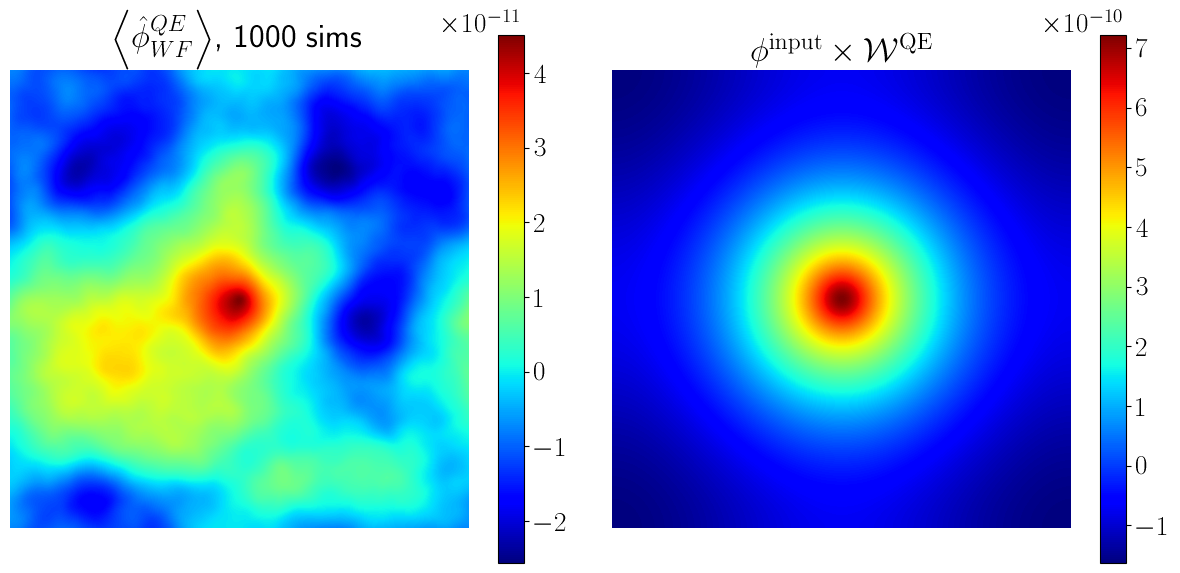

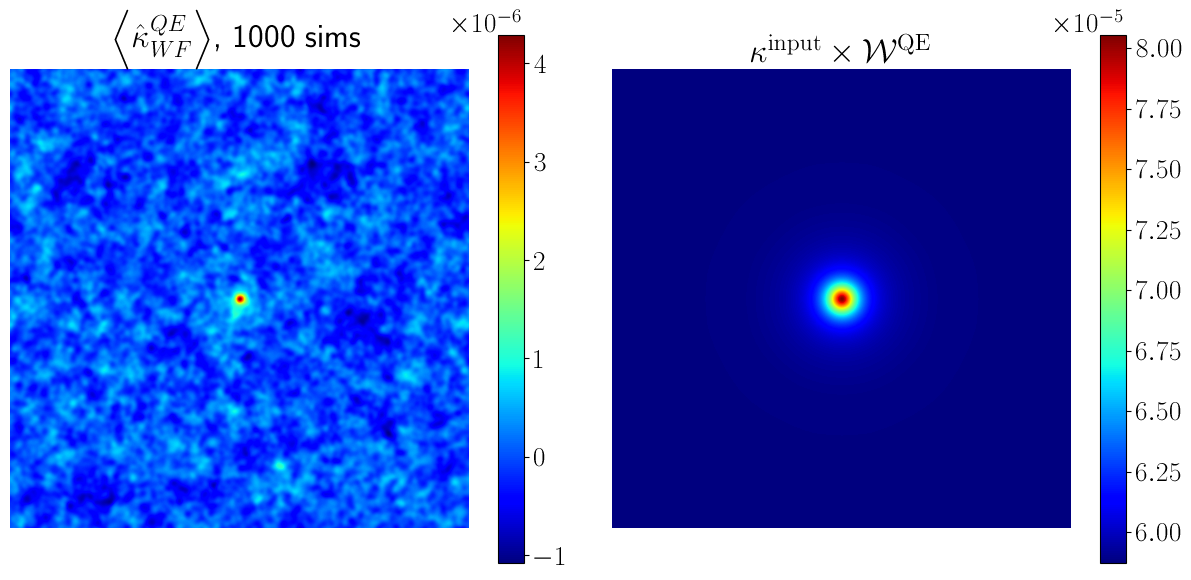

In [95]:
# plt.imshow(np.mean(np.array(pmaps), axis=0))
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(phi_input_wf_T))
titles = [r'$\left< \hat \phi^{QE}_{WF} \right>$' + f', {nmaps} sims', r'$\phi^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
for ax, dat, title in zip(axs, [pmap_wf_av_T, phi_input_wf_T], titles):
# for ax, dat, title in zip(axs, [np.mean(np.array(kmaps), axis=0), clustermaps.len_cmbs.kappa_map], titles):
    # im = ax.imshow(dat, vmax = vmax, vmin = -vmax, cmap = 'viridis')
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')
    
    
plt.savefig("WF_vs_input_lmax4k_lmin100_phi.png")
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(kappa_input_wf_T))
titles = [r'$\left< \hat \kappa^{QE}_{WF} \right>$' + f', {nmaps} sims', r'$\kappa^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
for ax, dat, title in zip(axs, [kmap_wf_av_T, kappa_input_wf_T], titles):
# for ax, dat, title in zip(axs, [np.mean(np.array(kmaps), axis=0), clustermaps.len_cmbs.kappa_map], titles):
    im = ax.imshow(dat, cmap=plt.cm.jet)
    #im = ax.imshow(dat)
    #im.tick_params(axis='both')
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')
    
    
plt.savefig("WF_vs_input_lmax4k_lmin100_kappa.png")

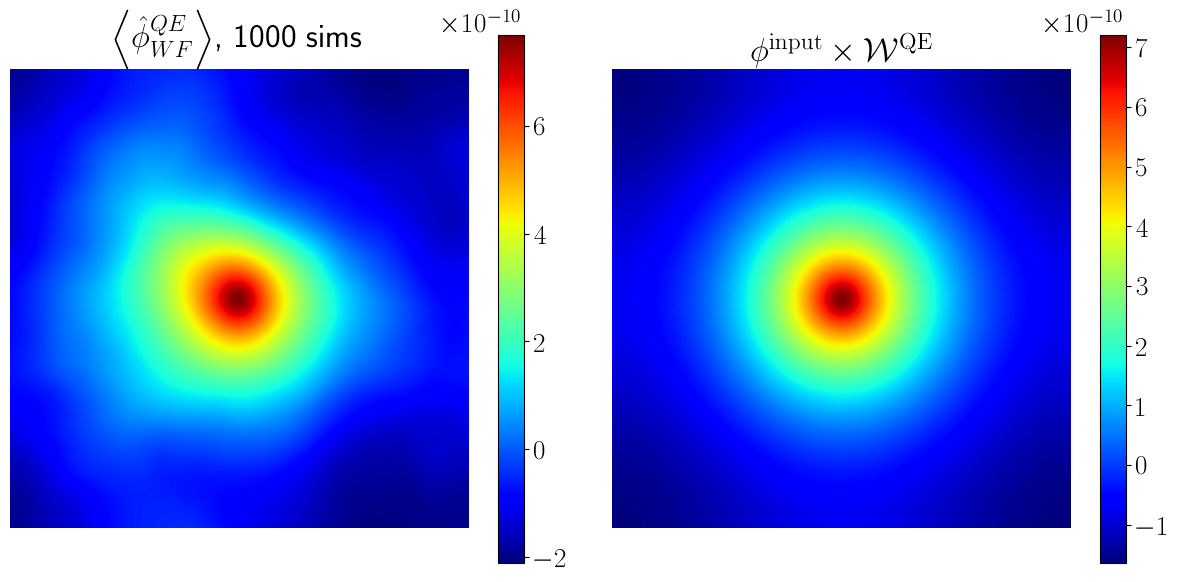

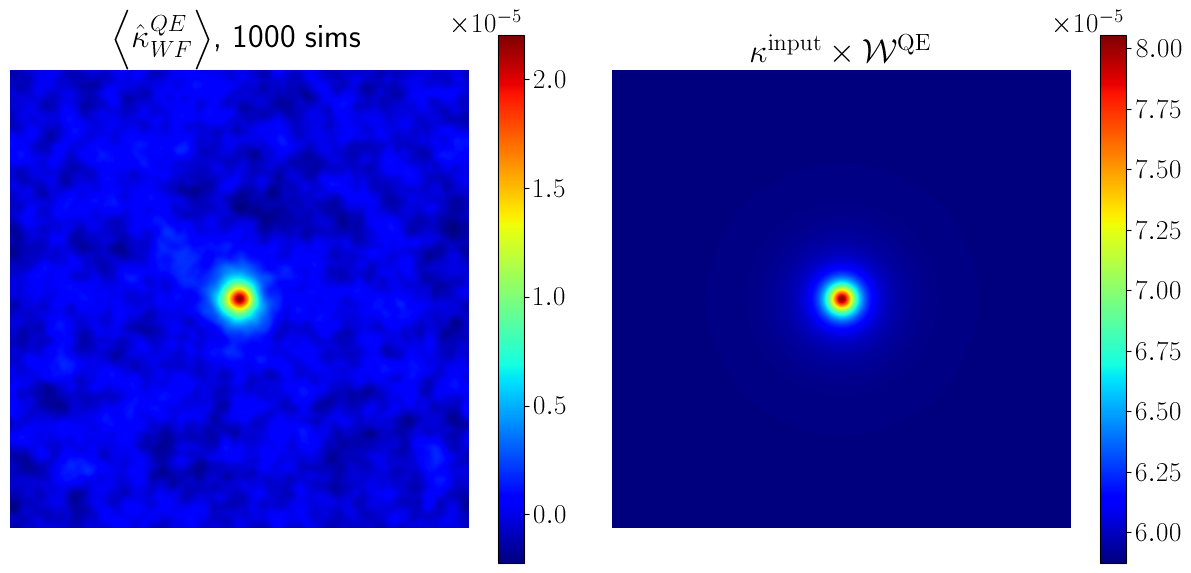

In [22]:
# plt.imshow(np.mean(np.array(pmaps), axis=0))
fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(phi_input_wf))
titles = [r'$\left< \hat \phi^{QE}_{WF} \right>$' + f', {nmaps} sims', r'$\phi^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
for ax, dat, title in zip(axs, [pmap_wf_av_P, phi_input_wf], titles):
# for ax, dat, title in zip(axs, [np.mean(np.array(kmaps), axis=0), clustermaps.len_cmbs.kappa_map], titles):
    # im = ax.imshow(dat, vmax = vmax, vmin = -vmax, cmap = 'viridis')
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')
    
plt.savefig("WF_vs_input_lmax4k_lmin100_phi_P.png")


fig, axs = plt.subplots(1, 2, figsize=(12, 6),)

fig.subplots_adjust(left=0.02, bottom=0.06, right=1, top=0.94, wspace=0.05)

vmax = np.max(np.abs(kappa_input_wf_P))
titles = [r'$\left< \hat \kappa^{QE}_{WF} \right>$' + f', {nmaps} sims', r'$\kappa^{\mathrm{input}} \times \mathcal{W}^{\mathrm{QE}} $']
for ax, dat, title in zip(axs, [kmap_wf_av_P, kappa_input_wf_P], titles):
# for ax, dat, title in zip(axs, [np.mean(np.array(kmaps), axis=0), clustermaps.len_cmbs.kappa_map], titles):
    # im = ax.imshow(dat, vmax = vmax, vmin = -vmax, cmap = 'viridis')
    im = ax.imshow(dat, cmap=plt.cm.jet)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.axis('off')
    
plt.savefig("WF_vs_input_lmax4k_lmin100_kappa_P.png")
#plt.savefig("WF_vs_input.png")

In [ ]:
from scipy.interpolate import UnivariateSpline
lmax=5000
ell, = np.where(isocov.lib_skyalm.get_Nell()[:lmax+1])
map2cl = isocov.lib_skyalm.map2cl(kappa_map)[ell]
map2cl_fit = UnivariateSpline(ell, map2cl, s=0)

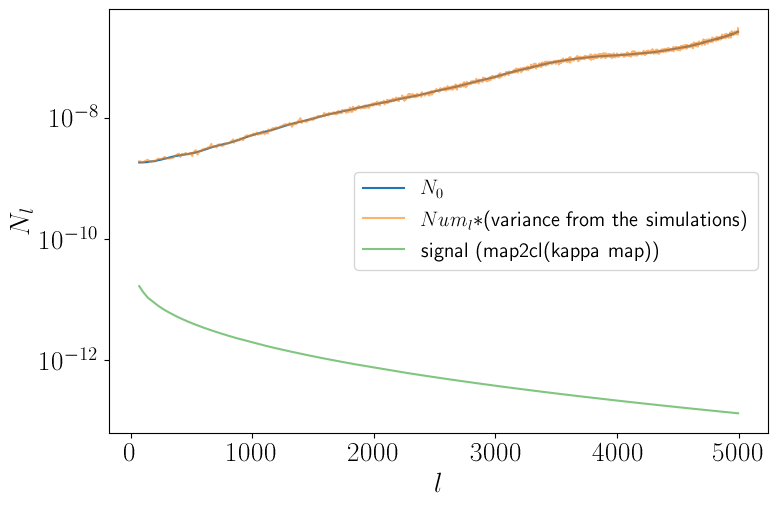

In [84]:
ell1, = np.where(isocov.lib_skyalm.get_Nell()[:5000])
ell1 = ell1[1:]
num_l = clustermaps.lib_skyalm.get_Nell()[ell1]
kappa_l_var  = np.var(kappa_l_hat_1_P, axis=0)
kappa_l_mean = np.mean(kappa_l_hat_1_P, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=1)

#axs.plot(ell1, cpp_fid[ell1]*pp_to_kk(ell1)+ cli(H0len)[ell1]*pp_to_kk(ell1), label='$C_l^{\kappa \kappa} + N_0$')
axs.plot(ell1, cli(H0len)[ell1]*pp_to_kk(ell1), label='$N_0$')
axs.plot(ell1, num_l*kappa_l_var[ell1], alpha=0.6, label='$Num_l*$(variance from the simulations)')
axs.plot(ell1, map2cl_fit(ell1), alpha=0.6, label='signal (map2cl(kappa map))')
#axs.plot(ell1, (kappa_ell**2)[ell1], alpha=0.6, label='weigner transform signal')

#axs.plot(ell1, kappa_l_mean[ell1], alpha=0.6, label='kappa mean')
axs.set_yscale("log")
axs.legend()
axs.set_xlabel(r"$l$")
axs.set_ylabel(r"$N_l$")
plt.savefig("noise_vs_signal.png")

In [108]:
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
N0s, N0s_curl = n0s.get_N0(beam_fwhm= 1.,nlev_t= 1.,nlev_p=1*np.sqrt(2.), lmin_CMB=ellmindat, lmax_CMB=ellmaxdat, lmax_out=ellmaxsky, cls_len=cls_unl_fid, cls_weight=cls_unl_fid)
NL = {}
NL['ptt'] = N0s['ptt'] #+ cpp_fid
NL['p_p'] = N0s['p_p'] #+ cpp_fid
NL['p'] = N0s['p'] #+ cpp_fid
#NL["ptt"] = cli(H0len)
lmax=5000
lmin=100
N_clusters = 1
ell = np.arange(lmin,lmax+1)
kappa0 = hprofile.get_kappa0(M200, z)
kappa_l = kappa_ell[ell]
kappa_l_1 = np.sqrt(map2cl_fit(ell))*lbox_rad    

snr_tt_1 = ((2*ell+1)/4/np.pi)*(kappa_l/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
snr_tt_2 = ((2*ell+1)/4/np.pi)*(kappa_l_1/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
sigma_kappa0_tt_th_1 = np.sqrt(1./np.sum(snr_tt_1))
sigma_kappa0_tt_th_2 = np.sqrt(1./np.sum(snr_tt_2))


In [141]:
print("The error with Weigner transform tenplate %f"%sigma_kappa0_tt_th_1) 
print("The error with new sqrt(map2cl) template %f"%sigma_kappa0_tt_th_2)

The error with Weigner transform tenplate 0.196516
The error with new sqrt(map2cl) template 0.121833


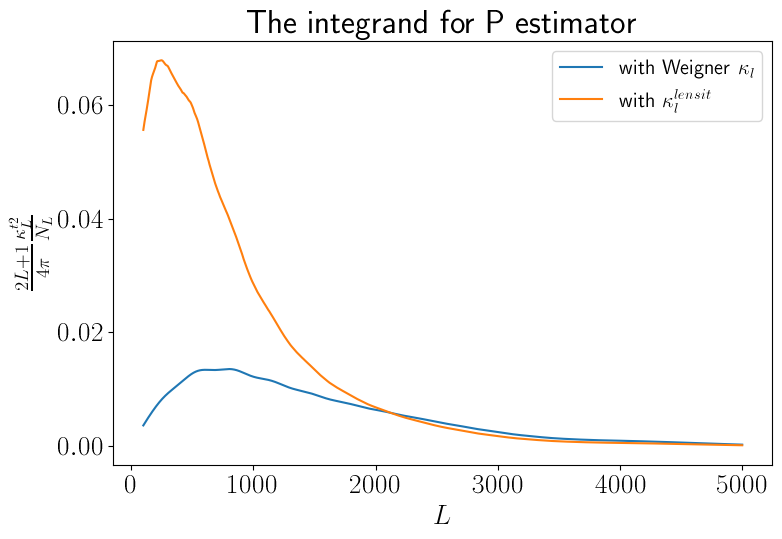

In [110]:
plt.plot(ell, snr_tt_1, label=r"with Weigner $\kappa_l$")
plt.plot(ell, snr_tt_2, label=r"with $\kappa_l^{lensit}$")

plt.xlabel(r'$L$')
plt.ylabel(r'$\frac{2L+1}{4\pi} \frac{\kappa_L^{t2}}{N_L}$')
# plt.grid()
plt.title("The integrand for P estimator")
plt.legend()
plt.savefig("integrand_compare_p.png")

In [145]:
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)
#N0s, N0s_curl = n0s.get_N0(beam_fwhm= 1.,nlev_t= 1.,nlev_p=1*np.sqrt(2.), lmin_CMB=ellmindat, lmax_CMB=ellmaxdat, lmax_out=ellmaxsky, cls_len=cls_unl_fid, cls_weight=cls_unl_fid)
NL = {}
NL['ptt'] = N0s['ptt'] #+ cpp_fid
NL['p_p'] = N0s['p_p'] #+ cpp_fid
NL['p'] = N0s['p'] #+ cpp_fid
#NL["ptt"] = cli(H0len)
lmax=5000
lmin=100
N_clusters = 1
ell = np.arange(lmin,lmax+1)
kappa0 = hprofile.get_kappa0(M200, z)
kappa_l = np.sqrt(map2cl_fit(ell))*lbox_rad  
#kappa_l = kappa_ell[ell]
snr_tt = ((2*ell+1)/4/np.pi)*(kappa_l/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
# snr_tt = ((2*ell+1)/4/np.pi)*(kappa_l)**2/(NL["ptt"][ell]*pp_to_kk(ell))
sigma_kappa0_tt_th = np.sqrt(1./np.sum(snr_tt))
ell, = np.where(clustermaps.lib_skyalm.get_Nell()[:lmax+1] > 1)
for i in range(len(ell)):
    if ell[i] >= lmin:
        m = i
        break
ell = ell[m:]
kappa0 = hprofile.get_kappa0(M200, z)
num_l = clustermaps.lib_skyalm.get_Nell()[ell]
kappa_l = np.sqrt(map2cl_fit(ell))*lbox_rad
#kappa_l = kappa_ell[ell]    
snr_tt = (num_l/lbox_rad**2)*(kappa_l/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))
# snr_tt = (num_l/lbox_rad**2)*(kappa_l)**2/(NL["ptt"][ell]*pp_to_kk(ell))
sigma_kappa0_tt_pix = np.sqrt(1./np.sum(snr_tt))


In [119]:
sigma_kappa0_tt_th,sigma_kappa0_tt_pix

(0.12183336550389215, 0.12284598070756204)

In [117]:
typ = 'T'
lib_qlm = isocov.lib_skyalm
kappa0 = hprofile.get_kappa0(M200,z)
lbox_amin = npix*lpix_amin #Physical size of the box in arcmin
lbox_rad = (lbox_amin/60)*(np.pi/180)

def kappa_0_fs_1(lmin, lmax, phi_obs_lm, NL):
    """ Get the kappa_0 estimate from one simulation
        Args: 
            lmin, lmax: the lrange for the sum in the numerator and denominator of the estimator
            phi_obs_lm: phi (lensing potential) estimate of a single simulation/observation
            NL: reconstruction niose of the phi estimate
        Returns:
            kappa_0 estiamte for the single simulation/observation
            
        P.S. the arguments is taken as the phi (not kappa) of the observation and accordingly the noise
    """
    ell, = np.where(clustermaps.lib_skyalm.get_Nell()[:lmax+1] > 1)
    for i in range(len(ell)):
        if ell[i] >= lmin:
            m = i
            break
    ell = ell[m:]
    kappa_l = np.sqrt(map2cl_fit(ell))*lbox_rad
    num_l = clustermaps.lib_skyalm.get_Nell()[ell]
    phi_obs_el = clustermaps.lib_skyalm.bin_realpart_inell(phi_obs_lm) #the average 
    denom_int = (num_l)*(kappa_l/lbox_rad/kappa0)**2 /(NL[ell]*pp_to_kk(ell))
    num_int = (num_l)*(kappa_l/lbox_rad/kappa0)*phi_obs_el[ell]*(ell+1)*ell /2 /(NL[ell]*pp_to_kk(ell)) ## since the observed quantity is phi and we need kappa
    denom1 = np.sum(denom_int)
    numer1 = np.sum(num_int)
    return numer1/denom1 

In [120]:
nmaps = 1000
plm0s_P = [None]*nmaps
plmqes_P = [None]*nmaps
klm0s_P = [None]*nmaps
klmqes_P = [None]*nmaps
kappa_0_sims_1_P_1 = [None]*nmaps
lmax, lmin= 5000,100
ell = np.arange(ellmaxsky+1)
if nsims >1:
    for idx in range(nmaps):
        print(idx)
        plm0s_P[idx], plmqes_P[idx], klm0s_P[idx], klmqes_P[idx], H0len_P, wf_qe_P, wf_qe_kk_P = get_starting_point(idx, 'QU', clustermaps)
        kappa_0_sims_1_P_1[idx] = kappa_0_fs_1(lmin=lmin, lmax=lmax, phi_obs_lm=plmqes_P[idx], NL=cli(H0len_P))

0
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
1
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
2
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with unl Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  
3
 I will be using data from ell=140 to ell=3999 only
 The sky band-limit is ell=8000
     [00:00:00]  (total

In [146]:
print("The input value of kappa 0 is %f"%kappa0)
print("Theory error with full sky %f"%sigma_kappa0_tt_th)
print("Theory error with box sky patch %f"%sigma_kappa0_tt_pix)
print("The mean value of kappa 0 from %i simulations is %f"%(nmaps,np.mean(kappa_0_sims_1_P_1)))
print("The error of kappa 0 from %i simulations is %f"%(nmaps,np.std(kappa_0_sims_1_P_1)))

The input value of kappa 0 is 0.130438
Theory error with full sky 0.121833
Theory error with box sky patch 0.122846
The mean value of kappa 0 from 1000 simulations is -0.006376
The error of kappa 0 from 1000 simulations is 0.125468
